In [1]:
# Libraries import
from datetime import datetime
from plotly.offline import init_notebook_mode
from googletrans import Translator

import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'Colombia GeoJson'
geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#geojson

In [4]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
state_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
state_counts = data['Estado'].value_counts().to_list()
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [5]:
# Data storage
date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)

In [6]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div):
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div):
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [7]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [8]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [9]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0.55,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Colombia: {len(data.index):,} casos confirmados de COVID-19 - {state_counts[1]+state_counts[2]+state_counts[4]+state_counts[5]:,} casos activos de COVID-19',
            showarrow = False
        ),
        dict(
            x=0.55,
            y=0.1,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0.55,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Casos activos VS Departamento (Estado)

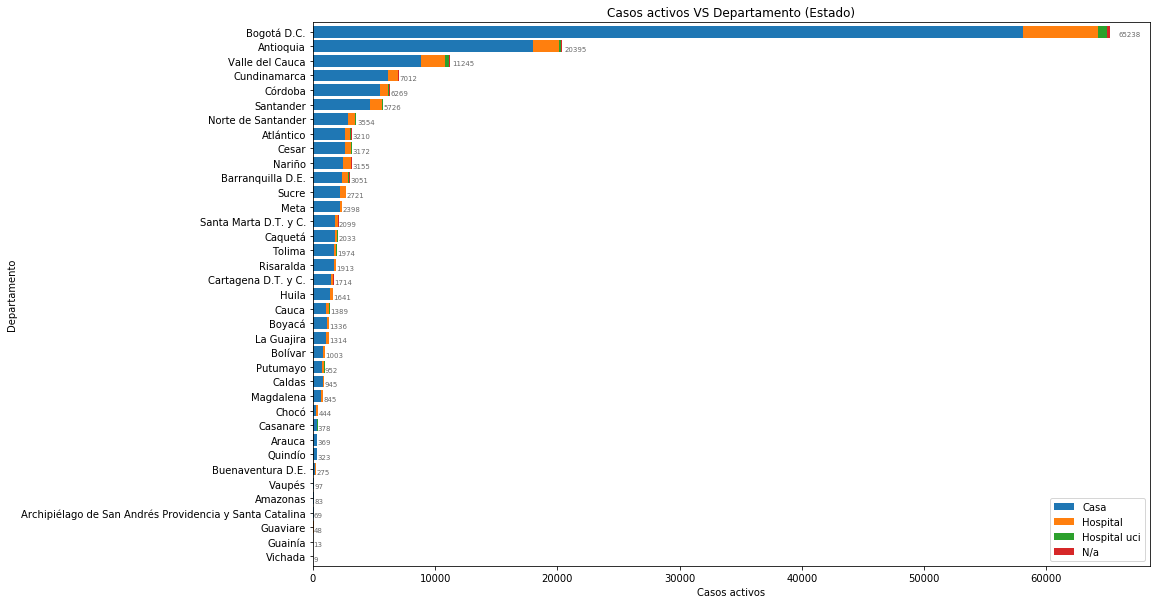

In [52]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos activos VS Departamento (Estado)'))
ax.set_xlabel('Casos activos')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [53]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         58108.0    6157.0   
Antioquia                                           17997.0    2100.0   
Valle del Cauca                                      8871.0    1938.0   
Cundinamarca                                         6158.0     789.0   
Córdoba                                              5468.0     650.0   
Santander                                            4654.0     965.0   
Norte de Santander                                   2906.0     546.0   
Atlántico                                            2632.0     417.0   
Cesar                                                2644.0     476.0   
Nariño                                               2486.0     588.0   
Barranquilla D.E.                                    2369.0     536.0   
Sucre                                                2223.0     453.0   
Meta                                                 2204.0     169.0   
Santa Marta D.T. y C.                                1833.0     236.0   
Caquetá                                              1779.0     230.0   
Tolima                                               1714.0     206.0   
Risaralda                                            1733.0     158.0   
Cartagena D.T. y C.                                  1445.0     193.0   
Huila                                                1423.0     201.0   
Cauca                                                1028.0     288.0   
Boyacá                                               1170.0     138.0   
La Guajira                                           1097.0     187.0   
Bolívar                                               839.0     122.0   
Putumayo                                              761.0     180.0   
Caldas                                                838.0      85.0   
Magdalena                                             631.0     159.0   
Chocó                                                 270.0     143.0   
Casanare                                              334.0      36.0   
Arauca                                                335.0      31.0   
Quindío                                               300.0      20.0   
Buenaventura D.E.                                     152.0      99.0   
Vaupés                                                 95.0       2.0   
Amazonas                                               70.0       8.0   
Archipiélago de San Andrés Providencia y Santa ...     56.0      11.0   
Guaviare                                               45.0       2.0   
Guainía                                                13.0       0.0   
Vichada                                                 9.0       0.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                706.0  267.0   
Antioquia                                                  220.0   78.0   
Valle del Cauca                                            344.0   92.0   
Cundinamarca                                                39.0   26.0   
Córdoba                                                     82.0   69.0   
Santander                                                   86.0   21.0   
Norte de Santander                                          91.0   11.0   
Atlántico                                                   78.0   83.0   
Cesar                                                       41.0   11.0   
Nariño                                                      55.0   26.0   
Barranquilla D.E.                                           53.0   93.0   
Sucre                                                       25.0   20.0   
Meta                                                        11.0   14.0   
Santa Marta D.T. y C.      

### - Casos confirmados VS Departamento (Estado)

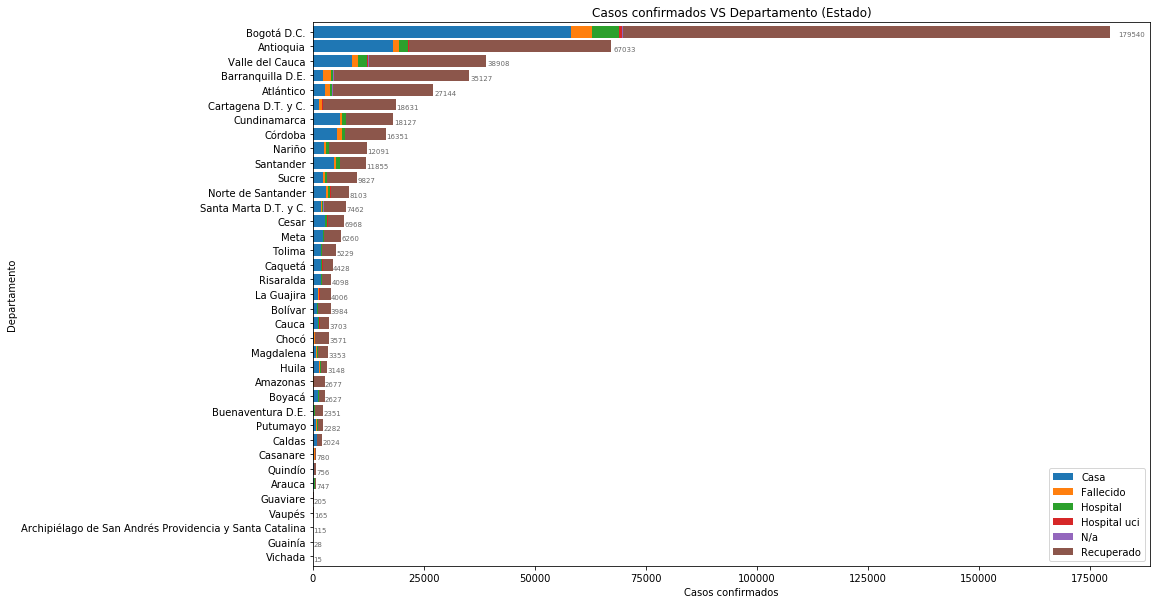

In [10]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [11]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         58108.0     4647.0   
Antioquia                                           17997.0     1293.0   
Valle del Cauca                                      8871.0     1323.0   
Barranquilla D.E.                                    2369.0     1588.0   
Atlántico                                            2632.0     1218.0   
Cartagena D.T. y C.                                  1445.0      495.0   
Cundinamarca                                         6158.0      472.0   
Córdoba                                              5468.0     1041.0   
Nariño                                               2486.0      436.0   
Santander                                            4654.0      470.0   
Sucre                                                2223.0      429.0   
Norte de Santander                                   2906.0      449.0   
Santa Marta D.T. y C.                                1833.0      280.0   
Cesar                                                2644.0      146.0   
Meta                                                 2204.0      113.0   
Tolima                                               1714.0      123.0   
Caquetá                                              1779.0      135.0   
Risaralda                                            1733.0       71.0   
La Guajira                                           1097.0      188.0   
Bolívar                                               839.0      161.0   
Cauca                                                1028.0      123.0   
Chocó                                                 270.0      125.0   
Magdalena                                             631.0      278.0   
Huila                                                1423.0       78.0   
Amazonas                                               70.0      107.0   
Boyacá                                               1170.0       56.0   
Buenaventura D.E.                                     152.0      156.0   
Putumayo                                              761.0      103.0   
Caldas                                                838.0       28.0   
Casanare                                              334.0       17.0   
Quindío                                               300.0       19.0   
Arauca                                                335.0       11.0   
Guaviare                                               45.0        0.0   
Vaupés                                                 95.0        1.0   
Archipiélago de San Andrés Providencia y Santa ...     56.0        0.0   
Guainía                                                13.0        2.0   
Vichada                                                 9.0        1.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           6157.0         706.0   
Antioquia                                             2100.0         220.0   
Valle del Cauca                                       1938.0         344.0   
Barranquilla D.E.                                      536.0          53.0   
Atlántico                                              417.0          78.0   
Cartagena D.T. y C.                                    193.0          43.0   
Cundinamarca                                           789.0          39.0   
Córdoba                                                650.0          82.0   
Nariño                                                 588.0          55.0   
Santander                                              965.0          86.0   
Sucre                                                  453.0          25.0   
Norte de Santander                                     546.0          91.0   
Santa Marta D.T. y C.

### - Casos confirmados VS Departamento (Sexo)

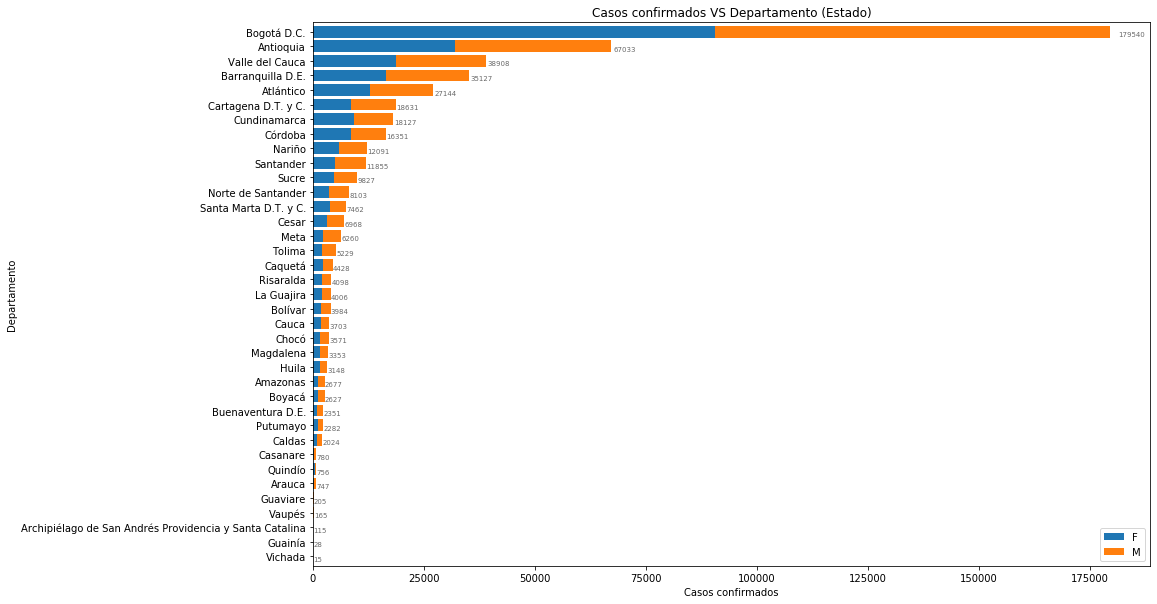

In [12]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [13]:
li.sort_values('Total', ascending=False)

Sexo                                                    F      M   Total
Departamento                                                            
Bogotá D.C.                                         90591  88949  179540
Antioquia                                           31911  35122   67033
Valle del Cauca                                     18772  20136   38908
Barranquilla D.E.                                   16500  18627   35127
Atlántico                                           12876  14268   27144
Cartagena D.T. y C.                                  8536  10095   18631
Cundinamarca                                         9162   8965   18127
Córdoba                                              8462   7889   16351
Nariño                                               5759   6332   12091
Santander                                            5009   6846   11855
Sucre                                                4685   5142    9827
Norte de Santander                                   3638   4465    8103
Santa Marta D.T. y C.                                3735   3727    7462
Cesar                                                3143   3825    6968
Meta                                                 2216   4044    6260
Tolima                                               2021   3208    5229
Caquetá                                              2182   2246    4428
Risaralda                                            2018   2080    4098
La Guajira                                           2009   1997    4006
Bolívar                                              1806   2178    3984
Cauca                                                1703   2000    3703
Chocó                                                1682   1889    3571
Magdalena                                            1684   1669    3353
Huila                                                1572   1576    3148
Amazonas                                             1158   1519    2677
Boyacá                                               1233   1394    2627
Buenaventura D.E.                                     876   1475    2351
Putumayo                                             1032   1250    2282
Caldas                                                978   1046    2024
Casanare                                              330    450     780
Quindío                                               371    385     756
Arauca                                                226    521     747
Guaviare                                               27    178     205
Vaupés                                                 78     87     165
Archipiélago de San Andrés Providencia y Santa ...     63     52     115
Guainía                                                10     18      28
Vichada                                                 3     12      15

### - Dataset COVID-19 (Colombia)

In [14]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
513755               2020-08-20           2020-08-20            2020-08-09   
513756               2020-08-20           2020-08-20            2020-08-09   
513757               2020-08-20           2020-08-20            2020-08-09   
513758               2020-08-20           2020-08-20            2020-08-09   
513759               2020-08-20           2020-08-20            2020-08-09   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                  2020-02-27 00:00:00            2020-03-13   
2                  2020-03-04 00:00:00            2020-03-19   
3                  2020-02-29 00:00:00            2020-03-15   
4                  2020-03-06 00:00:00            2020-03-26   
5                  2020-03-08 00:00:00            2020-03-23   
...                                ...                   ...   
513755             2020-08-05 00:00:00                   NaT   
513756             2020-08-05 00:00:00                   NaT   
513757             2020-08-06 00:00:00                   NaT   
513758             2020-08-02 00:00:00                   NaT   
513759             2020-08-06 00:00:00                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento Severidad  \
Id de caso                                                                      
1                         NaT          Bogotá d.c.      Bogotá D.C.      Leve   
2                         NaT  Guadalajara de buga  Valle del Cauca      Leve   
3                         NaT             Medellín        Antioquia      Leve   
4                         NaT             Medellín        Antioquia      Leve   
5                         NaT             Medellín        Antioquia      Leve   
...                       ...                  ...              ...       ...   
513755                    NaT           Valledupar            Cesar      Leve   
513756                    NaT           Valledupar            Cesar      Leve   
513757                    NaT             Riohacha       La Guajira      Leve   
513758                    NaT        Villavicencio             Meta      Leve   
513759                    NaT               Ibagué           Tolima      Leve   

                Estado  ...  Clasificación de edad Sexo Pertenecia Étnica  \
Id de caso              ...                                                 
1           Recuperado  ...                10 - 20    F              Otro   
2           Recuperado  ...                30 - 40    M              Otro   
3           Recuperado  ...                40 - 50    F              Otro   
4           Recuperado  ...                50 - 60    M              Otro   
5           Recuperado  ...                20 - 30    M              Otro   
...                ...  ...                    ...  ...               ...   
513755            Casa  ...                 0 - 10    M               NaN   
513756            Casa  ...                20 - 30    M               NaN   
513757            Casa  ...                30 - 40    F               NaN   
513758            Casa  ...                50 - 60    M               NaN   
513759            Casa  ...                30 - 40    M               NaN   

           Nombre Grupo Étnico         Tipo Tipo de recuperación  \
Id de caso                             

### - Mapa de influencia COVID-19 (Colombia)

In [15]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0.55,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Colombia: {len(data.index):,} casos confirmados de COVID-19 - {state_counts[1]+state_counts[2]+state_counts[4]+state_counts[5]:,} casos activos de COVID-19',
            showarrow = False
        ),
        dict(
            x=0.55,
            y=0.1,
            xref='paper',
            yref='paper',
            text=f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0.55,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

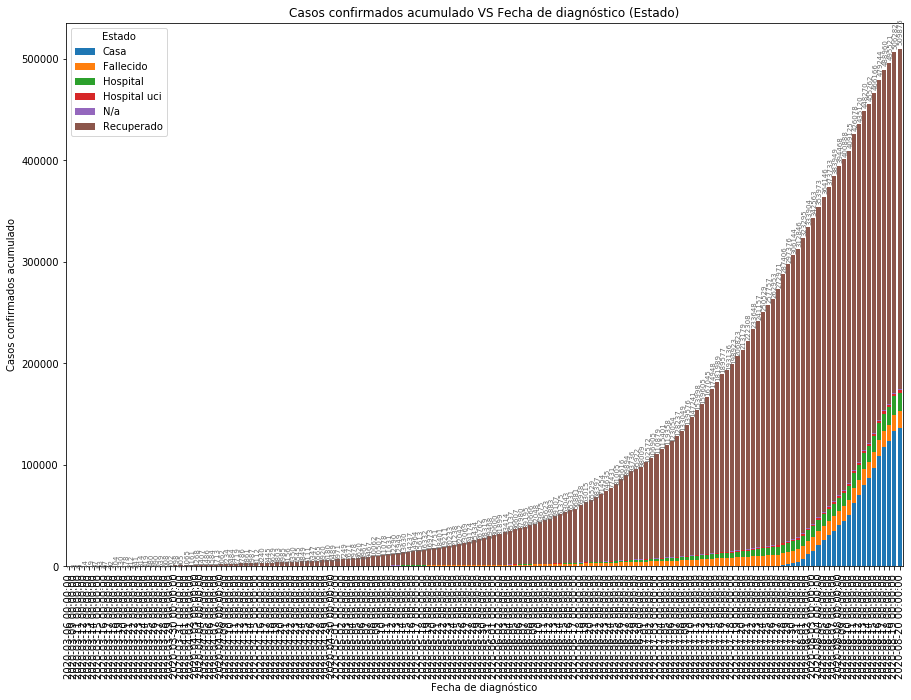

In [16]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [54]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                    Casa  Fallecido  Hospital  Hospital uci    N/a  \
Fecha de diagnóstico                                                       
2020-08-20            136658.0    15984.0   18429.0        2165.0  998.0   
2020-08-19            133386.0    15983.0   18127.0        2147.0  998.0   
2020-08-18            123435.0    15983.0   17542.0        2145.0  998.0   
2020-08-17            117352.0    15983.0   17066.0        2145.0  998.0   
2020-08-16            108431.0    15981.0   16655.0        2143.0  998.0   
2020-08-15             96561.0    15850.0   16155.0        2139.0  996.0   
2020-08-14             86763.0    15696.0   15641.0        2130.0  990.0   
2020-08-13             80390.0    15556.0   15296.0        2118.0  984.0   
2020-08-12             69801.0    15360.0   14741.0        2096.0  973.0   
2020-08-11             62157.0    15133.0   14200.0        2068.0  965.0   
2020-08-10             50612.0    14847.0   13470.0        1996.0  950.0   
2020-08-09             44268.0    14687.0   13093.0        1973.0  935.0   
2020-08-08             40251.0    14516.0   12717.0        1942.0  931.0   
2020-08-07             35188.0    14269.0   12366.0        1895.0  921.0   
2020-08-06             30575.0    14045.0   11984.0        1824.0  908.0   
2020-08-05             25691.0    13810.0   11632.0        1758.0  892.0   
2020-08-04             20908.0    13576.0   11228.0        1699.0  875.0   
2020-08-03             15114.0    13309.0   10854.0        1634.0  862.0   
2020-08-02             12047.0    13021.0   10428.0        1584.0  846.0   
2020-08-01              7554.0    12693.0    9969.0        1525.0  832.0   
2020-07-31              4251.0    12380.0    9477.0        1477.0  813.0   
2020-07-30              3275.0    12171.0    9222.0        1444.0  798.0   
2020-07-29              2034.0    11904.0    8917.0        1384.0  786.0   
2020-07-28              1056.0    11640.0    8567.0        1320.0  766.0   
2020-07-27               269.0    11125.0    8018.0        1249.0  733.0   
2020-07-26               145.0    10829.0    7719.0        1198.0  714.0   
2020-07-25               143.0    10601.0    7520.0        1163.0  707.0   
2020-07-24               141.0    10310.0    7192.0        1120.0  696.0   
2020-07-23               121.0    10027.0    6867.0        1076.0  676.0   
2020-07-22                79.0     9669.0    6505.0        1028.0  649.0   
2020-07-21                58.0     9242.0    6068.0         969.0  625.0   
2020-07-20                45.0     8904.0    5769.0         909.0  614.0   
2020-07-19                40.0     8639.0    5438.0         870.0  605.0   
2020-07-18                39.0     8366.0    5153.0         842.0  589.0   
2020-07-17                39.0     8129.0    4967.0         808.0  568.0   
2020-07-16                36.0     7960.0    4850.0         791.0  560.0   
2020-07-15                36.0     7681.0    4577.0         753.0  541.0   
2020-07-14                30.0     7391.0    4346.0         716.0  532.0   
2020-07-13                28.0     7107.0    4101.0         684.0  510.0   
2020-07-12                28.0     6843.0    3833.0         645.0  489.0   
2020-07-11                27.0     6632.0    3671.0         615.0  476.0   
2020-07-10                26.0     6375.0    3454.0         595.0  450.0   
2020-07-09                24.0     6157.0    3251.0         564.0  434.0   
2020-07-08                24.0     5865.0    2994.0         519.0  425.0   
2020-07-07                24.0     5626.0    2839.0         491.0  416.0   
2020-07-06                20.0     5415.0    2636.0         460.0  398.0   
2020-07-05                16.0     5284.0    2554.0         446.0  386.0   
2020-07-04                16.0     5135.0    2449.0         428.0  372.0   
2020-07-03                15.0     4942.0    2258.0         402.0  353.0   
2020-07-02                14.0     4745.0    2126.0         388.0  344.0   
2020-07-01                14.0     4541.0    198

### - Casos confirmados VS Fecha de diagnóstico (Estado)

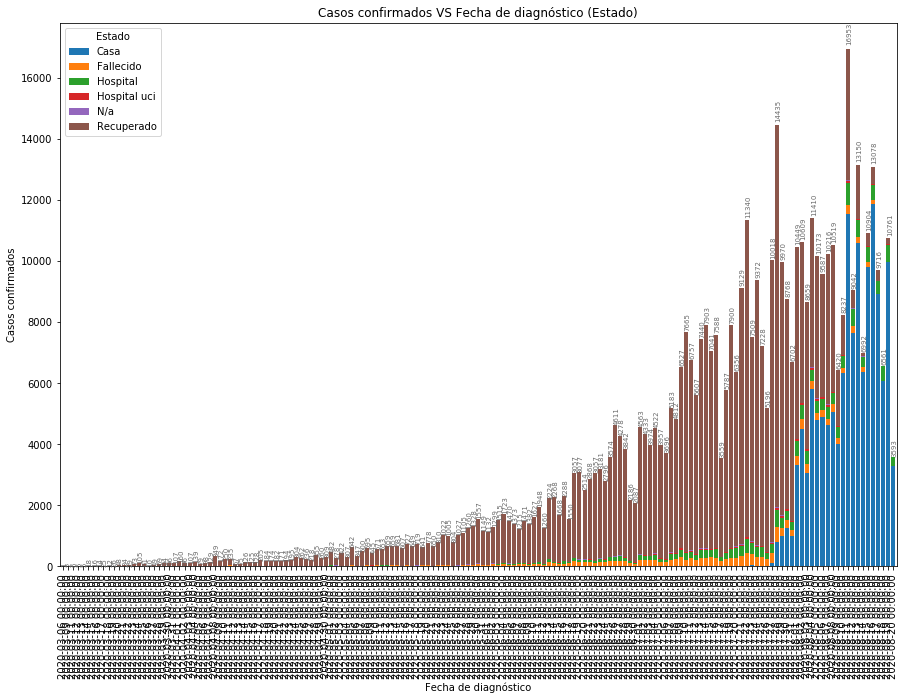

In [18]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [19]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                   Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                     
2020-06-22                0.0       93.0      66.0           8.0  10.0   
2020-06-23                0.0      144.0      88.0          10.0  14.0   
2020-06-24                0.0      140.0      76.0          14.0   9.0   
2020-06-25                1.0      162.0     127.0          15.0  13.0   
2020-06-26                0.0      184.0     118.0          15.0  15.0   
2020-06-27                1.0      175.0     161.0          11.0  12.0   
2020-06-28                0.0      163.0     125.0           9.0   8.0   
2020-06-29                0.0      107.0      66.0          10.0   5.0   
2020-06-30                1.0       59.0      60.0           6.0   5.0   
2020-07-01                0.0      212.0     150.0          21.0  12.0   
2020-07-02                0.0      204.0     139.0          27.0  12.0   
2020-07-03                1.0      197.0     132.0          14.0   9.0   
2020-07-04                1.0      193.0     191.0          26.0  19.0   
2020-07-05                0.0      149.0     105.0          18.0  14.0   
2020-07-06                4.0      131.0      82.0          14.0  12.0   
2020-07-07                4.0      211.0     203.0          31.0  18.0   
2020-07-08                0.0      239.0     155.0          28.0   9.0   
2020-07-09                0.0      292.0     257.0          45.0   9.0   
2020-07-10                2.0      218.0     203.0          31.0  16.0   
2020-07-11                1.0      257.0     217.0          20.0  26.0   
2020-07-12                1.0      211.0     162.0          30.0  13.0   
2020-07-13                0.0      264.0     268.0          39.0  21.0   
2020-07-14                2.0      284.0     245.0          32.0  22.0   
2020-07-15                6.0      290.0     231.0          37.0   9.0   
2020-07-16                0.0      279.0     273.0          38.0  19.0   
2020-07-17                3.0      169.0     117.0          17.0   8.0   
2020-07-18                0.0      237.0     186.0          34.0  21.0   
2020-07-19                1.0      273.0     285.0          28.0  16.0   
2020-07-20                5.0      265.0     331.0          39.0   9.0   
2020-07-21               13.0      338.0     299.0          60.0  11.0   
2020-07-22               21.0      427.0     437.0          59.0  24.0   
2020-07-23               42.0      358.0     362.0          48.0  27.0   
2020-07-24               20.0      283.0     325.0          44.0  20.0   
2020-07-25                2.0      291.0     328.0          43.0  11.0   
2020-07-26                2.0      228.0     199.0          35.0   7.0   
2020-07-27              124.0      296.0     299.0          51.0  19.0   
2020-07-28              787.0      515.0     549.0          71.0  33.0   
2020-07-29              978.0      264.0     350.0          64.0  20.0   
2020-07-30             1241.0      267.0     305.0          60.0  12.0   
2020-07-31              976.0      209.0     255.0          33.0  15.0   
2020-08-01             3303.0      313.0     492.0          48.0  19.0   
2020-08-02             4493.0      328.0     459.0          59.0  14.0   
2020-08-03             3067.0      288.0     426.0          50.0  16.0   
2020-08-04             5794.0      267.0     374.0          65.0  13.0   
2020-08-05             4783.0      234.0     404.0          59.0  17.0   
2020-08-06             4884.0      235.0     352.0          66.0  16.0   
2020-08-07             4613.0      224.0     382.0          71.0  13.0   
2020-08-08             5063.0      247.0     351.0          47.0  10.0   
2020-08-09             4017.0      171.0     376.0          31.0   4.0   
2020-08-10             6344.0      160.0     377.0          23.0  15.0   
2020-08-11            11545.0      286.0     730.0          72.0  15.0   
2020-08-12             7644.0      227.0     541.0          28.0   8.0   
2020

### - Casos confirmados VS Clasificación de edad (Estado)

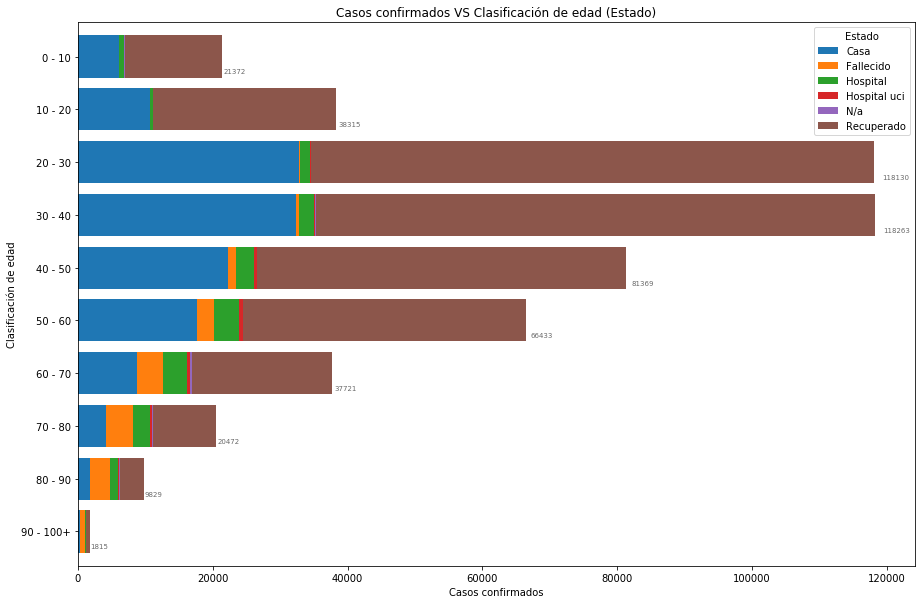

In [20]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [21]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  6038         30       764            56   26   
10 - 20                10702         24       406            33   19   
20 - 30                32765        212      1481            87   47   
30 - 40                32329        538      2169           197   37   
40 - 50                22268       1209      2700           329   83   
50 - 60                17648       2469      3764           541  123   
60 - 70                 8711       3926      3499           513  208   
70 - 80                 4153       4084      2398           327  232   
80 - 90                 1775       3011      1156            90  197   
90 - 100+                301        680       182             9   49   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      14458  
10 - 20                     27131  
20 - 30                     83538  
30 - 40                     82993  
40 - 50                     54780  
50 - 60                     41888  
60 - 70                     20864  
70 - 80                      9278  
80 - 90                      3600  
90 - 100+                     594

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

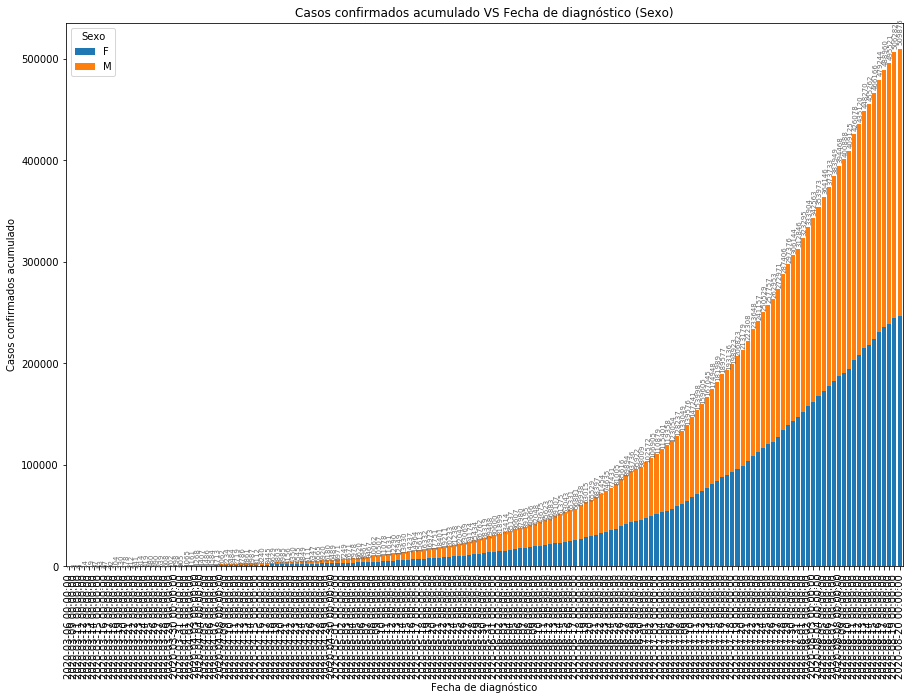

In [22]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [23]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-06-22             32636.0   38818.0
2020-06-23             34207.0   40428.0
2020-06-24             35551.0   41880.0
2020-06-25             37121.0   43884.0
2020-06-26             39315.0   46301.0
2020-06-27             41312.0   48582.0
2020-06-28             43152.0   50584.0
2020-06-29             44152.0   51770.0
2020-06-30             45124.0   52885.0
2020-07-01             47197.0   55375.0
2020-07-02             49220.0   57685.0
2020-07-03             51076.0   59803.0
2020-07-04             53100.0   62301.0
2020-07-05             54933.0   64425.0
2020-07-06             56683.0   66371.0
2020-07-07             59088.0   69149.0
2020-07-08             61396.0   71653.0
2020-07-09             64358.0   75218.0
2020-07-10             67859.0   79382.0
2020-07-11             71068.0   82930.0
2020-07-12             73736.0   85869.0
2020-07-13             77303.0   89742.0
2020-07-14             80901.0   94047.0
2020-07-15             84237.0   97752.0
2020-07-16             87962.0  101615.0
2020-07-17             89714.0  103422.0
2020-07-18             92488.0  106435.0
2020-07-19             96272.0  110551.0
2020-07-20             99240.0  113939.0
2020-07-21            103512.0  118796.0
2020-07-22            108626.0  125022.0
2020-07-23            112172.0  128985.0
2020-07-24            116500.0  134029.0
2020-07-25            120156.0  137601.0
2020-07-26            122536.0  140417.0
2020-07-27            127333.0  145638.0
2020-07-28            134365.0  153041.0
2020-07-29            139305.0  158071.0
2020-07-30            143565.0  162579.0
2020-07-31            146936.0  165910.0
2020-08-01            151994.0  171301.0
2020-08-02            157415.0  176489.0
2020-08-03            161604.0  180959.0
2020-08-04            167317.0  186656.0
2020-08-05            172429.0  191717.0
2020-08-06            177175.0  196558.0
2020-08-07            182165.0  201784.0
2020-08-08            187275.0  207193.0
2020-08-09            190586.0  210302.0
2020-08-10            194716.0  214409.0
2020-08-11            203505.0  222573.0
2020-08-12            207982.0  227138.0
2020-08-13            214568.0  233702.0
2020-08-14            218132.0  237130.0
2020-08-15            223701.0  242465.0
2020-08-16            230540.0  248704.0
2020-08-17            235672.0  253288.0
2020-08-18            238862.0  256659.0
2020-08-19            244479.0  261803.0
2020-08-20            246239.0  263636.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

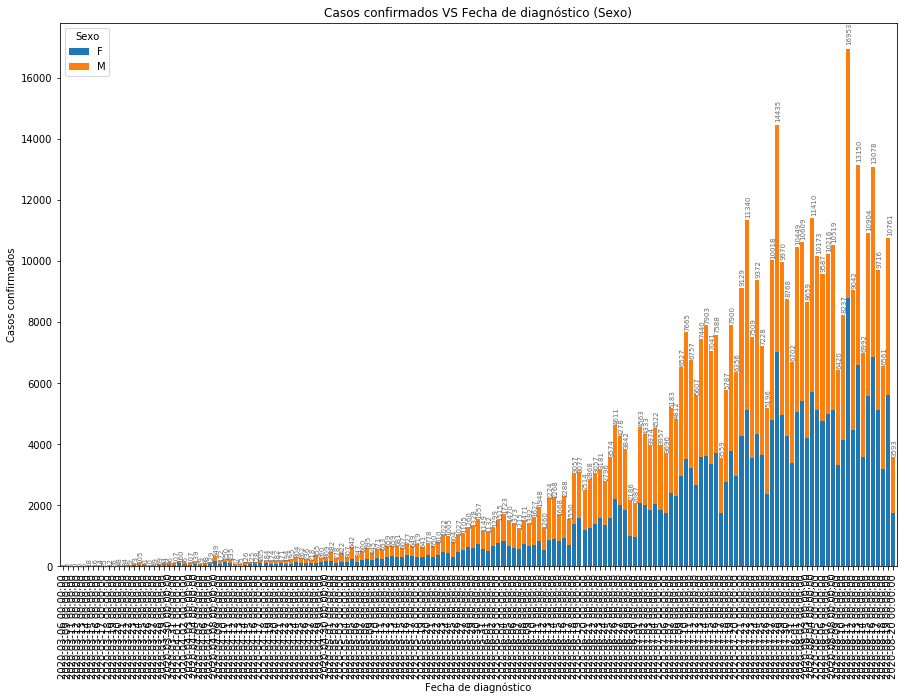

In [24]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [25]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-06-22            1382.0  1675.0
2020-06-23            1571.0  1610.0
2020-06-24            1344.0  1452.0
2020-06-25            1570.0  2004.0
2020-06-26            2194.0  2417.0
2020-06-27            1997.0  2281.0
2020-06-28            1840.0  2002.0
2020-06-29            1000.0  1186.0
2020-06-30             972.0  1115.0
2020-07-01            2073.0  2490.0
2020-07-02            2023.0  2310.0
2020-07-03            1856.0  2118.0
2020-07-04            2024.0  2498.0
2020-07-05            1833.0  2124.0
2020-07-06            1750.0  1946.0
2020-07-07            2405.0  2778.0
2020-07-08            2308.0  2504.0
2020-07-09            2962.0  3565.0
2020-07-10            3501.0  4164.0
2020-07-11            3209.0  3548.0
2020-07-12            2668.0  2939.0
2020-07-13            3567.0  3873.0
2020-07-14            3598.0  4305.0
2020-07-15            3336.0  3705.0
2020-07-16            3725.0  3863.0
2020-07-17            1752.0  1807.0
2020-07-18            2774.0  3013.0
2020-07-19            3784.0  4116.0
2020-07-20            2968.0  3388.0
2020-07-21            4272.0  4857.0
2020-07-22            5114.0  6226.0
2020-07-23            3546.0  3963.0
2020-07-24            4328.0  5044.0
2020-07-25            3656.0  3572.0
2020-07-26            2380.0  2816.0
2020-07-27            4797.0  5221.0
2020-07-28            7032.0  7403.0
2020-07-29            4940.0  5030.0
2020-07-30            4260.0  4508.0
2020-07-31            3371.0  3331.0
2020-08-01            5058.0  5391.0
2020-08-02            5421.0  5188.0
2020-08-03            4189.0  4470.0
2020-08-04            5713.0  5697.0
2020-08-05            5112.0  5061.0
2020-08-06            4746.0  4841.0
2020-08-07            4990.0  5226.0
2020-08-08            5110.0  5409.0
2020-08-09            3311.0  3109.0
2020-08-10            4130.0  4107.0
2020-08-11            8789.0  8164.0
2020-08-12            4477.0  4565.0
2020-08-13            6586.0  6564.0
2020-08-14            3564.0  3428.0
2020-08-15            5569.0  5335.0
2020-08-16            6839.0  6239.0
2020-08-17            5132.0  4584.0
2020-08-18            3190.0  3371.0
2020-08-19            5617.0  5144.0
2020-08-20            1760.0  1833.0

### - Casos confirmados VS Clasificación de edad (Sexo)

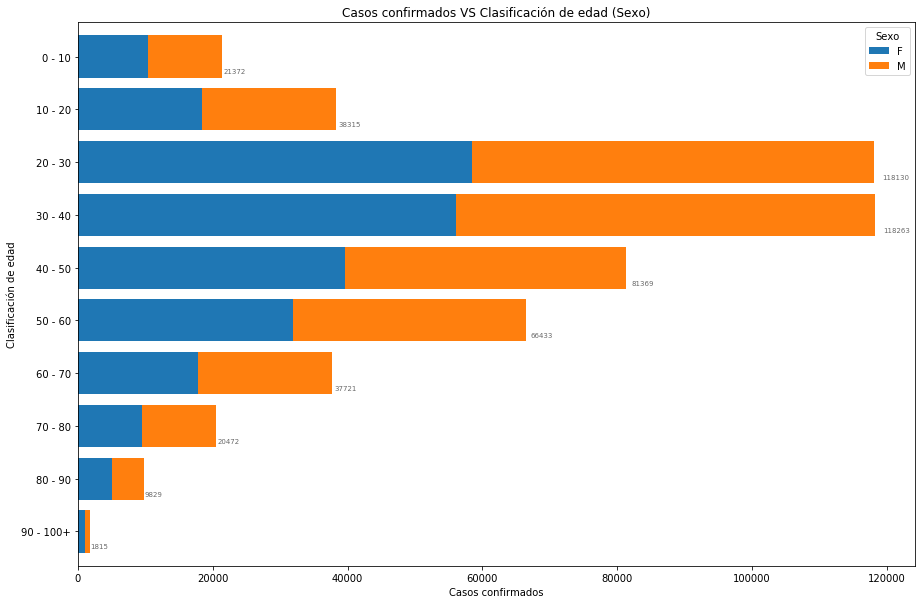

In [26]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [27]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 10457  10915
10 - 20                18333  19982
20 - 30                58441  59689
30 - 40                56097  62166
40 - 50                39558  41811
50 - 60                31884  34549
60 - 70                17790  19931
70 - 80                 9484  10988
80 - 90                 4983   4846
90 - 100+               1030    785

### - Casos confirmados VS Estado (Sexo)

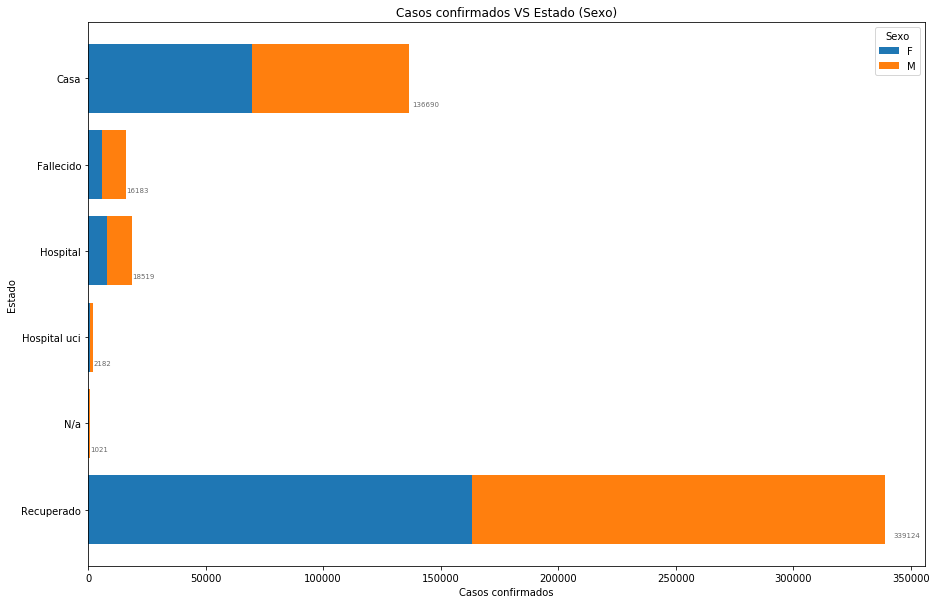

In [28]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [29]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           69733   66957
Fallecido       5814   10369
Hospital        7959   10560
Hospital uci     743    1439
N/a              434     587
Recuperado    163374  175750

### - Casos confirmados VS Tipo de contagio (Sexo)

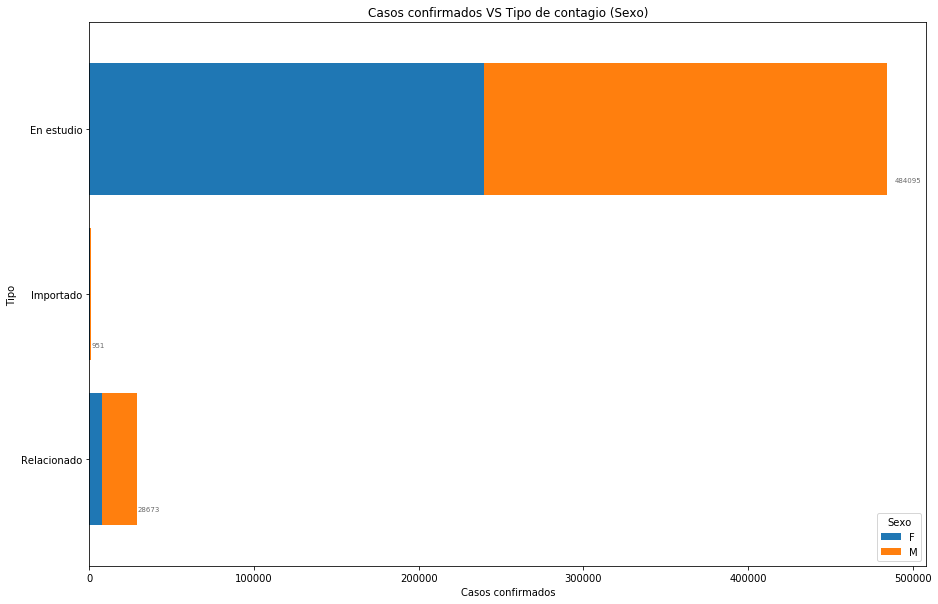

In [30]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo de contagio (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [31]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   239729  244366
Importado       446     505
Relacionado    7882   20791

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

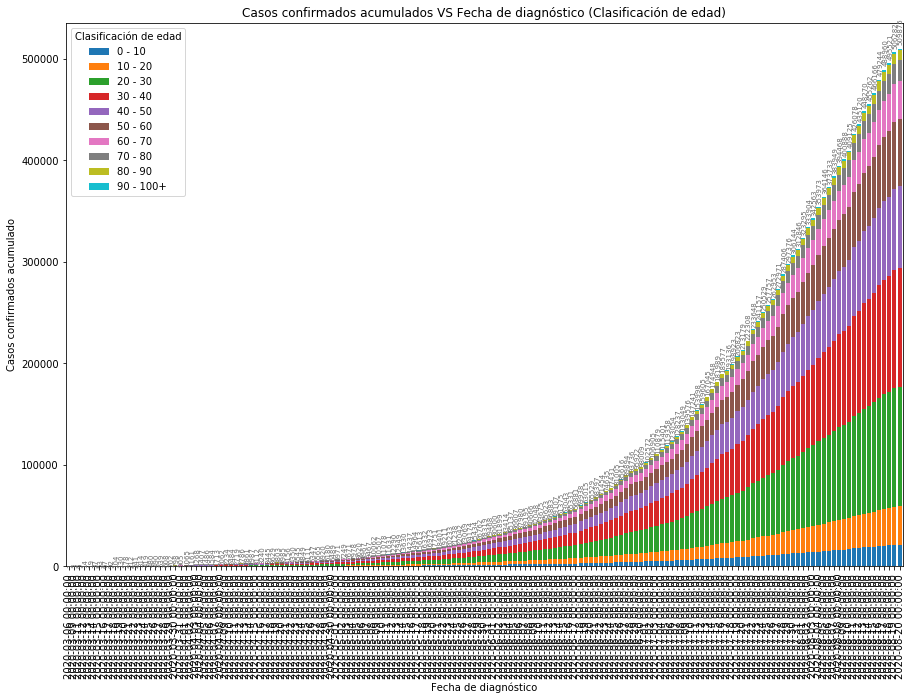

In [32]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [33]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-06-22               3388     6300    16436    15685    10801     8883   
2020-06-23               3540     6553    17166    16391    11293     9290   
2020-06-24               3665     6759    17744    17025    11751     9683   
2020-06-25               3818     7030    18539    17834    12293    10149   
2020-06-26               4036     7362    19588    18952    12988    10712   
2020-06-27               4225     7684    20577    19916    13653    11274   
2020-06-28               4365     7909    21443    20890    14287    11760   
2020-06-29               4464     8082    21986    21394    14634    12011   
2020-06-30               4559     8254    22500    21893    14952    12259   
2020-07-01               4762     8565    23584    22915    15662    12851   
2020-07-02               4928     8885    24584    23887    16354    13422   
2020-07-03               5108     9162    25534    24786    16973    13925   
2020-07-04               5263     9475    26668    25923    17633    14446   
2020-07-05               5415     9748    27562    26829    18245    14995   
2020-07-06               5594    10033    28371    27713    18819    15478   
2020-07-07               5794    10330    29598    28978    19708    16121   
2020-07-08               5983    10656    30690    30120    20478    16745   
2020-07-09               6203    11083    32243    31687    21518    17557   
2020-07-10               6488    11633    34095    33568    22675    18545   
2020-07-11               6738    12080    35723    35195    23760    19401   
2020-07-12               6978    12505    37032    36465    24674    20142   
2020-07-13               7233    12994    38812    38179    25887    21129   
2020-07-14               7529    13576    40681    40056    27163    22104   
2020-07-15               7821    14107    42277    41660    28286    23032   
2020-07-16               8163    14611    43980    43459    29530    24049   
2020-07-17               8286    14829    44780    44320    30076    24500   
2020-07-18               8506    15170    46073    45729    31030    25251   
2020-07-19               8819    15829    47902    47581    32339    26231   
2020-07-20               9096    16287    49253    49038    33404    27058   
2020-07-21               9456    16910    51405    51207    34876    28205   
2020-07-22               9859    17747    54106    53783    36648    29741   
2020-07-23              10134    18261    55778    55522    37842    30726   
2020-07-24              10454    18976    57968    57798    39308    31942   
2020-07-25              10736    19457    59596    59491    40466    32919   
2020-07-26              10947    19781    60781    60711    41270    33596   
2020-07-27              11328    20491    63139    63067    42917    34787   
2020-07-28              11949    21612    66435    66327    45211    36695   
2020-07-29              12319    22333    68813    68747    46857    37903   
2020-07-30              12655    23032    70955    70834    48143    39039   
2020-07-31              12926    23478    72457    72437    49287    39855   
2020-08-01              13334    24323    74985    74926    50890    41175   
2020-08-02              13771    25037    77383    77306    52682    42664   
2020-08-03              14091    25637    79350    79317    54002    43857   
2020-08-04              14570    26442    81974    81976    55870    45425   
2020-08-05              14992    27155    84312    84320    57515    46764   
2020-08-06              15436    27888    86445    86513    59045    48012   
2020-08-07              15849    28652    88782    88920    60664    49336   
2020-08-08              16255    29418    91166    91490    62311    50713   
2020-08-09              16494    29832    92650    92877    63373    51578   
2020-08-10            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

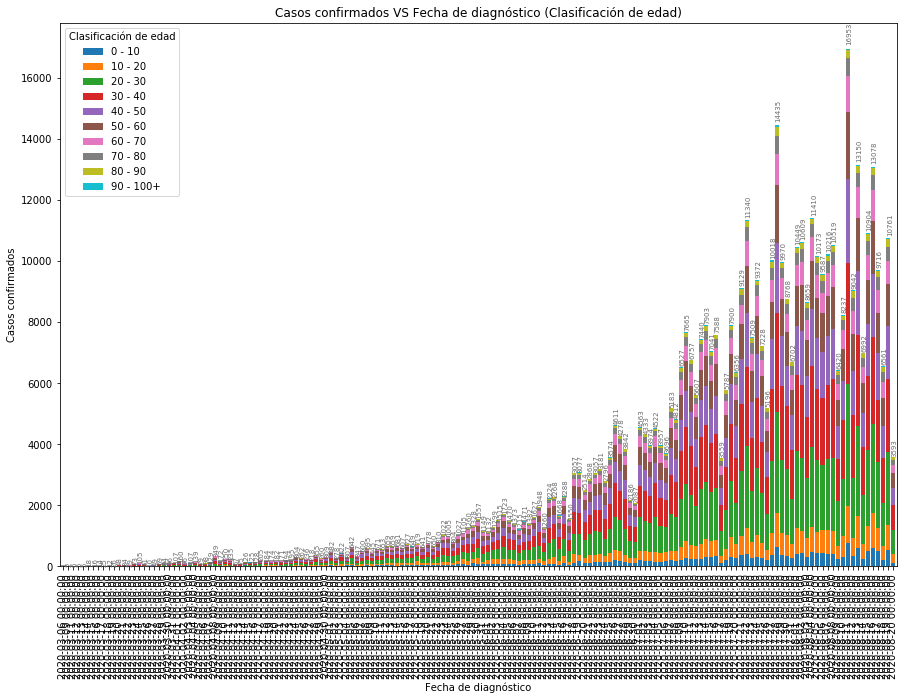

In [34]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [35]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-06-22                146      227      777      705      443      388   
2020-06-23                152      253      730      706      492      407   
2020-06-24                125      206      578      634      458      393   
2020-06-25                153      271      795      809      542      466   
2020-06-26                218      332     1049     1118      695      563   
2020-06-27                189      322      989      964      665      562   
2020-06-28                140      225      866      974      634      486   
2020-06-29                 99      173      543      504      347      251   
2020-06-30                 95      172      514      499      318      248   
2020-07-01                203      311     1084     1022      710      592   
2020-07-02                166      320     1000      972      692      571   
2020-07-03                180      277      950      899      619      503   
2020-07-04                155      313     1134     1137      660      521   
2020-07-05                152      273      894      906      612      549   
2020-07-06                179      285      809      884      574      483   
2020-07-07                200      297     1227     1265      889      643   
2020-07-08                189      326     1092     1142      770      624   
2020-07-09                220      427     1553     1567     1040      812   
2020-07-10                285      550     1852     1881     1157      988   
2020-07-11                250      447     1628     1627     1085      856   
2020-07-12                240      425     1309     1270      914      741   
2020-07-13                255      489     1780     1714     1213      987   
2020-07-14                296      582     1869     1877     1276      975   
2020-07-15                292      531     1596     1604     1123      928   
2020-07-16                342      504     1703     1799     1244     1017   
2020-07-17                123      218      800      861      546      451   
2020-07-18                220      341     1293     1409      954      751   
2020-07-19                313      659     1829     1852     1309      980   
2020-07-20                277      458     1351     1457     1065      827   
2020-07-21                360      623     2152     2169     1472     1147   
2020-07-22                403      837     2701     2576     1772     1536   
2020-07-23                275      514     1672     1739     1194      985   
2020-07-24                320      715     2190     2276     1466     1216   
2020-07-25                282      481     1628     1693     1158      977   
2020-07-26                211      324     1185     1220      804      677   
2020-07-27                381      710     2358     2356     1647     1191   
2020-07-28                621     1121     3296     3260     2294     1908   
2020-07-29                370      721     2378     2420     1646     1208   
2020-07-30                336      699     2142     2087     1286     1136   
2020-07-31                271      446     1502     1603     1144      816   
2020-08-01                408      845     2528     2489     1603     1320   
2020-08-02                437      714     2398     2380     1792     1489   
2020-08-03                320      600     1967     2011     1320     1193   
2020-08-04                479      805     2624     2659     1868     1568   
2020-08-05                422      713     2338     2344     1645     1339   
2020-08-06                444      733     2133     2193     1530     1248   
2020-08-07                413      764     2337     2407     1619     1324   
2020-08-08                406      766     2384     2570     1647     1377   
2020-08-09                239      414     1484     1387     1062      865   
2020-08-10            

### - Casos confirmados VS Estado (Clasificación de edad)

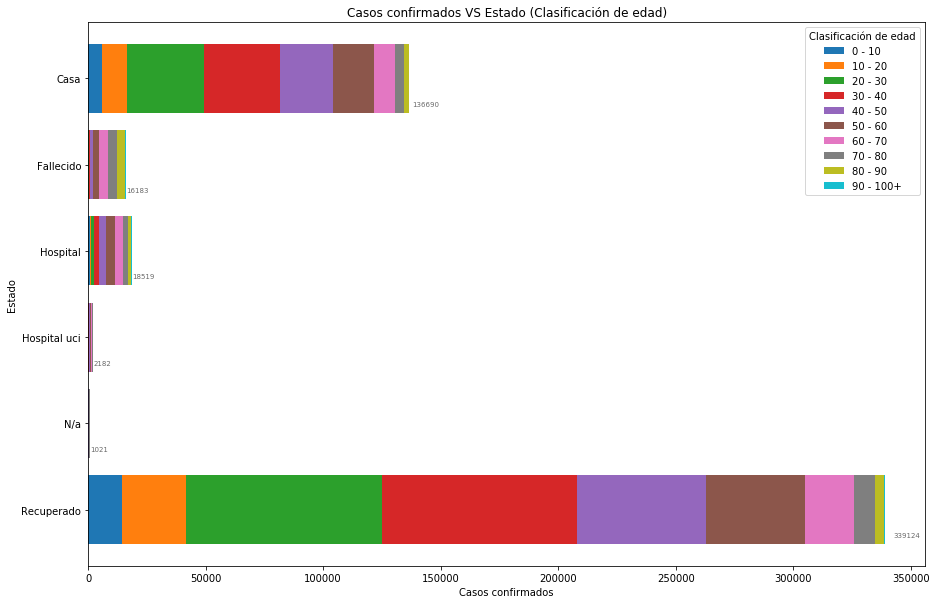

In [36]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [37]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     6038    10702    32765    32329    22268    17648   
Fallecido                  30       24      212      538     1209     2469   
Hospital                  764      406     1481     2169     2700     3764   
Hospital uci               56       33       87      197      329      541   
N/a                        26       19       47       37       83      123   
Recuperado              14458    27131    83538    82993    54780    41888   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      8711     4153     1775        301  
Fallecido                 3926     4084     3011        680  
Hospital                  3499     2398     1156        182  
Hospital uci               513      327       90          9  
N/a                        208      232      197         49  
Recuperado               20864     9278     3600        594

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

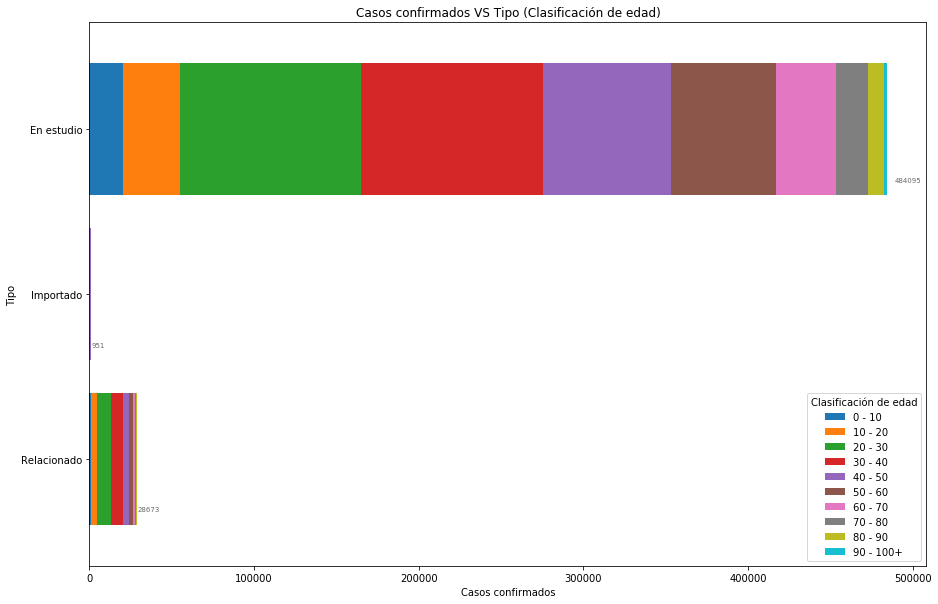

In [38]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [39]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              20394    34613   109730   110633    77578    63802   
Importado                   5       37      240      221      166      143   
Relacionado               973     3665     8160     7409     3625     2488   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               36324    19852     9448       1721  
Importado                   94       35        9          1  
Relacionado               1303      585      372         93

## #StayHome 🏠 #QuédateEnCasa - #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>